In [264]:
%matplotlib inline

In [308]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime as dt
from sqlalchemy import create_engine

In [512]:
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])

### Dataframe Set-Up

We manually imported the data into a folder titled "dataproj" from Kaggle due to the login requirement.

In [267]:
bars = pd.read_csv('dataproj/bar_locations.csv', encoding="utf-8", dtype="unicode")

In [268]:
parties = pd.read_csv('dataproj/party_in_nyc.csv', encoding="utf-8", dtype="unicode")

Let's take a look at the data we're working with.

In [269]:
bars.dtypes

Location Type    object
Incident Zip     object
City             object
Borough          object
Latitude         object
Longitude        object
num_calls        object
dtype: object

In [270]:
bars.head(5)

,Location Type,Incident Zip,City,Borough,Latitude,Longitude,num_calls
0,Club/Bar/Restaurant,10308.0,STATEN ISLAND,STATEN ISLAND,40.544096088789225,-74.14115468967245,40
1,Club/Bar/Restaurant,10012.0,NEW YORK,MANHATTAN,40.72979348359966,-73.99884181131429,18
2,Club/Bar/Restaurant,10308.0,STATEN ISLAND,STATEN ISLAND,40.54420876737653,-74.14103979012613,21
3,Club/Bar/Restaurant,10034.0,NEW YORK,MANHATTAN,40.86637625588829,-73.92825812322728,160
4,Club/Bar/Restaurant,11220.0,BROOKLYN,BROOKLYN,40.6352068552889,-74.02028461083884,17


Now, in order to best work with the dataset we need to begin converting these columns into manageable datatypes. The following should all be numeric:

In [271]:
bars["Incident Zip"] = pd.to_numeric(bars["Incident Zip"], downcast='integer')
bars["num_calls"] = pd.to_numeric(bars["num_calls"], downcast='integer')
bars["Latitude"] = pd.to_numeric(bars["Latitude"])
bars["Longitude"] = pd.to_numeric(bars["Longitude"])

In [272]:
# Now the categorical columns
bars["Borough"] =  pd.Categorical(bars["Borough"], ordered=False)
bars["City"] =  pd.Categorical(bars["City"], ordered=False)
bars["Location Type"] =  pd.Categorical(bars["Location Type"], ordered=False)

Now, let's look at the other dataframe: parties

In [273]:
parties.dtypes

Created Date     object
Closed Date      object
Location Type    object
Incident Zip     object
City             object
Borough          object
Latitude         object
Longitude        object
dtype: object

In [274]:
parties.head(5)

,Created Date,Closed Date,Location Type,Incident Zip,City,Borough,Latitude,Longitude
0,2015-12-31 00:01:15,2015-12-31 03:48:04,Store/Commercial,10034.0,NEW YORK,MANHATTAN,40.86618344001468,-73.91893042945345
1,2015-12-31 00:02:48,2015-12-31 04:36:13,Store/Commercial,10040.0,NEW YORK,MANHATTAN,40.85932419390543,-73.93123733660876
2,2015-12-31 00:03:25,2015-12-31 00:40:15,Residential Building/House,10026.0,NEW YORK,MANHATTAN,40.79941540978025,-73.95337116858667
3,2015-12-31 00:03:26,2015-12-31 01:53:38,Residential Building/House,11231.0,BROOKLYN,BROOKLYN,40.6782851094981,-73.99466779426595
4,2015-12-31 00:05:10,2015-12-31 03:49:10,Residential Building/House,10033.0,NEW YORK,MANHATTAN,40.85030372032608,-73.93851562699031


In [275]:
# Categorical data
parties["Location Type"] =  pd.Categorical(parties["Location Type"], ordered=False)
parties["Borough"] =  pd.Categorical(parties["Borough"], ordered=False)
parties["City"] =  pd.Categorical(parties["City"], ordered=False)

In [276]:
# Numeric data
parties["Incident Zip"] = pd.to_numeric(parties["Incident Zip"], downcast='integer')
parties["Latitude"] = pd.to_numeric(parties["Latitude"])
parties["Longitude"] = pd.to_numeric(parties["Longitude"])

In [277]:
# Datetime data
parties["Created Date"] = pd.to_datetime(parties["Created Date"], format='%Y%m%d %H:%M:%S')
parties["Closed Date"] = pd.to_datetime(parties["Closed Date"], format='%Y%m%d %H:%M:%S')

In [278]:
# Pandas documentation shows that we can pull these out from a dateframe!
parties["Hour"] = parties['Created Date'].dt.hour # Could be useful to analyze the number of complaints at different hours?
parties["Weekday"] = parties['Created Date'].dt.weekday_name # Complaints on diff. days of week?

In [279]:
# Let's make them an integer and a categorical
parties["Hour"] = pd.to_numeric(parties["Hour"], downcast='integer')
parties["Weekday"] = pd.Categorical(parties["Weekday"], ordered=False)

Moving forward, we chose to add a unique id column to each of these tables in order to facilitate looking at similarities
between, say, the areas where there are lots of bar noise complaints and apartments. Not only that but in any case we wouldn't be able to assign a primary key to any of the existing columns as rows likely overlap, e.g. in zip code.

In [280]:
bars.insert(0, 'uniqueID', range(0, len(bars)))
parties.insert(0, 'uniqueID', range(0, len(parties)))

In [281]:
# Let's take a look at each 
bars.describe(include='all')

,uniqueID,Location Type,Incident Zip,City,Borough,Latitude,Longitude,num_calls
count,2440.000000,2440,2440.000000,2440,2440,2440.000000,2440.000000,2440.000000
unique,NaN,1,NaN,38,6,NaN,NaN,NaN
top,NaN,Club/Bar/Restaurant,NaN,NEW YORK,MANHATTAN,NaN,NaN,NaN
freq,NaN,2440,NaN,1078,1076,NaN,NaN,NaN
mean,1219.500000,NaN,10631.856967,NaN,NaN,40.733985,-73.952497,37.025820
std,704.511651,NaN,591.657847,NaN,NaN,0.066349,0.060292,59.641884
min,0.000000,NaN,10001.000000,NaN,NaN,40.511255,-74.251277,10.000000
25%,609.750000,NaN,10019.000000,NaN,NaN,40.702064,-73.987822,14.000000
50%,1219.500000,NaN,10463.000000,NaN,NaN,40.728351,-73.957928,21.000000
75%,1829.250000,NaN,11217.000000,NaN,NaN,40.765226,-73.925422,40.000000


In [282]:
parties.describe(include='all')

,uniqueID,Created Date,Closed Date,Location Type,Incident Zip,City,Borough,Latitude,Longitude,Hour,Weekday
count,225414.000000,225414,224619,225414,224424.000000,224424,225414,223946.000000,223946.000000,225414.000000,225414
unique,NaN,222579,212047,6,NaN,48,6,NaN,NaN,NaN,7
top,NaN,2016-05-14 23:18:15,2016-11-08 12:59:35,Residential Building/House,NaN,BROOKLYN,BROOKLYN,NaN,NaN,NaN,Saturday
freq,NaN,3,3,146040,NaN,68909,68905,NaN,NaN,NaN,61161
first,NaN,2015-12-31 00:01:15,1900-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2016-12-31 23:58:52,2017-01-02 03:50:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,112706.500000,NaN,NaN,NaN,10720.020992,NaN,NaN,40.749730,-73.924889,13.334394,NaN
std,65071.561127,NaN,NaN,NaN,576.827879,NaN,NaN,0.082068,0.063779,9.128362,NaN
min,0.000000,NaN,NaN,NaN,83.000000,NaN,NaN,40.498820,-74.251277,0.000000,NaN
25%,56353.250000,NaN,NaN,NaN,10039.000000,NaN,NaN,40.684648,-73.958245,2.000000,NaN


### SQL Set-Up and Queries

Part 1: Set-Up
Let's take these and put them into SQL for the future.

In [283]:
# Let's connect to the SQL database as shown in class
conn_string = 'mysql://{user}:{password}@{host}:{port}/'.format(
    user='root', password='dwdstudent2015', 
    host = 'localhost', port=3306)
engine = create_engine(conn_string)

In [284]:
# Now we create the database, also as specified in class
engine.execute('CREATE DATABASE IF NOT EXISTS parties_in_nyc')
engine.execute('USE parties_in_nyc')

In [262]:
# And now we add all of our dataframes as tables in SQL
# We ensure that we're starting fresh by dropping the tables should they already exist
engine.execute('DROP TABLE IF EXISTS flights')
engine.execute('DROP TABLE IF EXISTS airports')
engine.execute('DROP TABLE IF EXISTS airlines')

/usr/local/lib/python3.5/dist-packages/sqlalchemy/engine/default.py:470: Warning: (1051, "Unknown table 'parties_in_nyc.flights'")
  cursor.execute(statement, parameters)
/usr/local/lib/python3.5/dist-packages/sqlalchemy/engine/default.py:470: Warning: (1051, "Unknown table 'parties_in_nyc.airports'")
  cursor.execute(statement, parameters)
/usr/local/lib/python3.5/dist-packages/sqlalchemy/engine/default.py:470: Warning: (1051, "Unknown table 'parties_in_nyc.airlines'")
  cursor.execute(statement, parameters)


In [263]:
# Now let's make the tables
bars.to_sql(name='bar_complaints', index=False, if_exists='replace', con=engine, chunksize=1000)
parties.to_sql(name='party_complaints', index=False, if_exists='replace', con=engine, chunksize=1000)

Part 2: Let's start working with SQL

In [285]:
conn_string_parties = 'mysql://{user}:{password}@{host}:{port}/{db}'.format(
    user='root', 
    password='dwdstudent2015', 
    host = 'localhost', 
    port=3306, 
    db='parties_in_nyc'
)
engine_parties = create_engine(conn_string_parties)

In [432]:
# Borough's with the most bar complaints
query = '''
SELECT Borough, SUM(num_calls) AS Sum
FROM bar_complaints 
WHERE Borough != 'Unspecified'
GROUP BY Borough
ORDER BY Sum DESC;
'''
df_bars = pd.read_sql(query, con=engine_parties)
df_bars = df_bars.set_index("Borough")

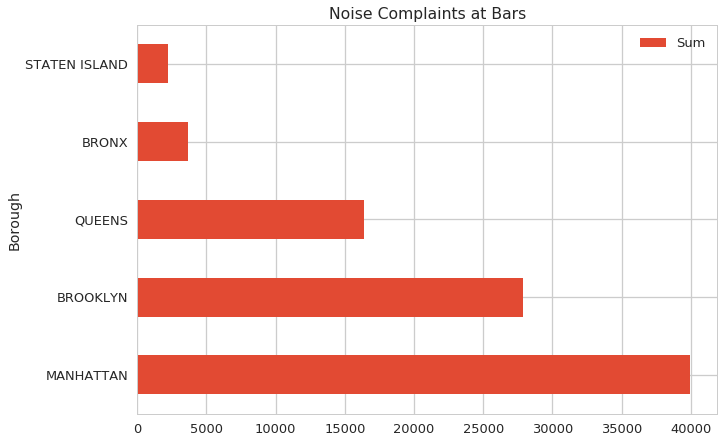

In [513]:
df_bars.plot(kind='barh', title='Noise Complaints at Bars')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd851078828>], dtype=object)

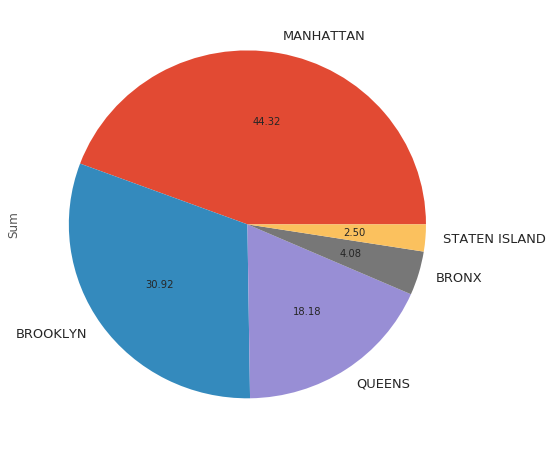

In [505]:
# Let's make this into a pie chart for better visualization
df_bars.plot.pie(subplots=True, figsize=(8, 8), legend=False, autopct='%.2f')

In [526]:
# Number of party complaints per borough
query_1b = '''
SELECT Borough, COUNT(*) AS cnt
FROM party_complaints
GROUP BY Borough
ORDER BY cnt DESC
'''
df_parties = pd.read_sql(query_1b, con=engine_parties)
df_parties = df_parties.set_index("Borough")

In [529]:
# Let's get rid of the unspecified column
df_parties = df_parties.drop("Unspecified")

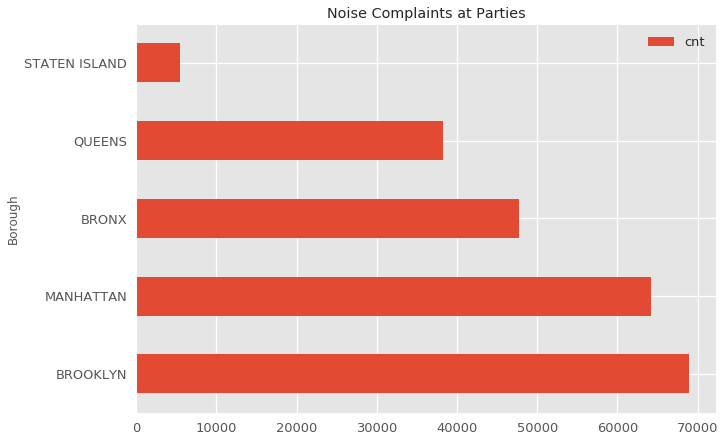

In [530]:
df_parties.plot(kind='barh', title='Noise Complaints at Parties')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd838b16dd8>], dtype=object)

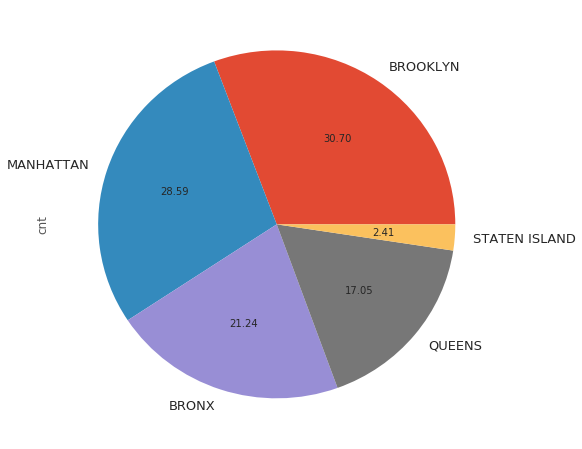

In [531]:
# Again, let's bring in a pie chart here
df_parties.plot.pie(subplots=True, figsize=(8, 8), legend=False, autopct='%.2f')

In [438]:
# Now, let's look at the average number of calls
query_2 = '''
SELECT Borough, AVG(num_calls) AS Avg
FROM bar_complaints
WHERE Borough != 'Unspecified'
GROUP BY Borough
ORDER BY Avg DESC
'''
df_bars2 = pd.read_sql(query_2, con=engine_parties)
df_bars2 = df_bars2.set_index("Borough")

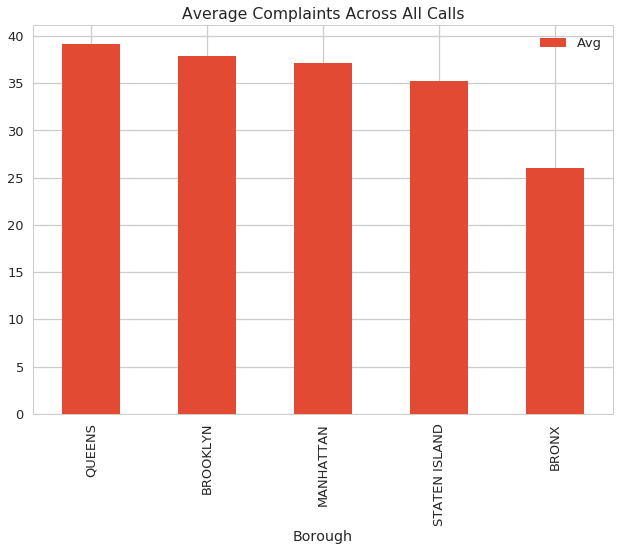

In [440]:
df_bars2.plot(kind='bar', title='Average Complaints Across All Calls')

In [454]:
# Let's take a look at the most popular zips for private parties
query_3 ='''
SELECT `Incident Zip`, COUNT(*) as cnt
FROM party_complaints 
GROUP BY `Incident Zip`
ORDER BY cnt DESC
'''
df_parties = pd.read_sql(query_3, con=engine_parties)
df_parties = df_parties.set_index('Incident Zip')

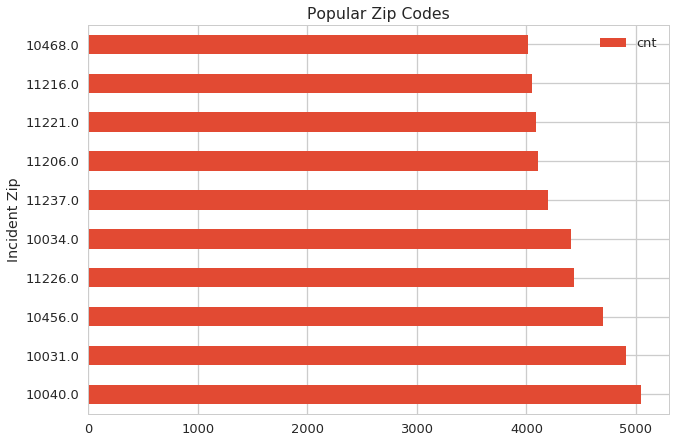

In [457]:
df_parties.head(10).plot(kind='barh', title='Popular Zip Codes')

In [514]:
# Turned ggplot on for these two for visibility
plt.style.use('ggplot')

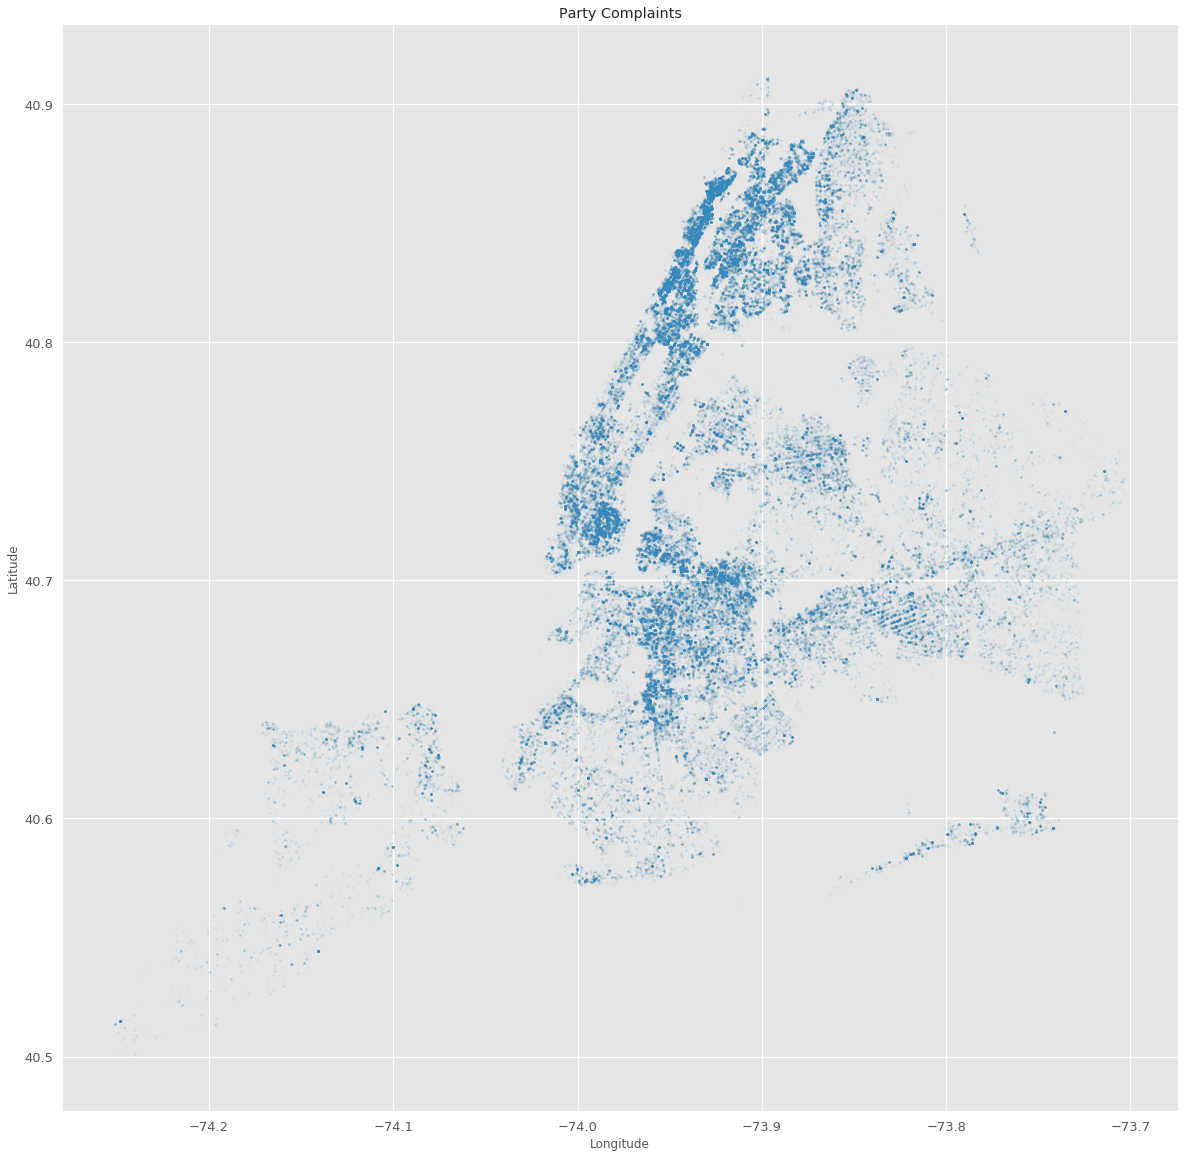

In [451]:
parties [
    (parties.Latitude > 40) &
    (parties.Latitude < 41) & 
    (parties.Longitude < -50) &
    (parties.Longitude > -74.5) & 
    (parties['uniqueID']>=1) 
].plot (
    kind='scatter',
    x = 'Longitude',
    y = 'Latitude',
    figsize = (20, 20), 
    alpha = 0.05, 
    s = 3, 
    title = 'Party Complaints'
)

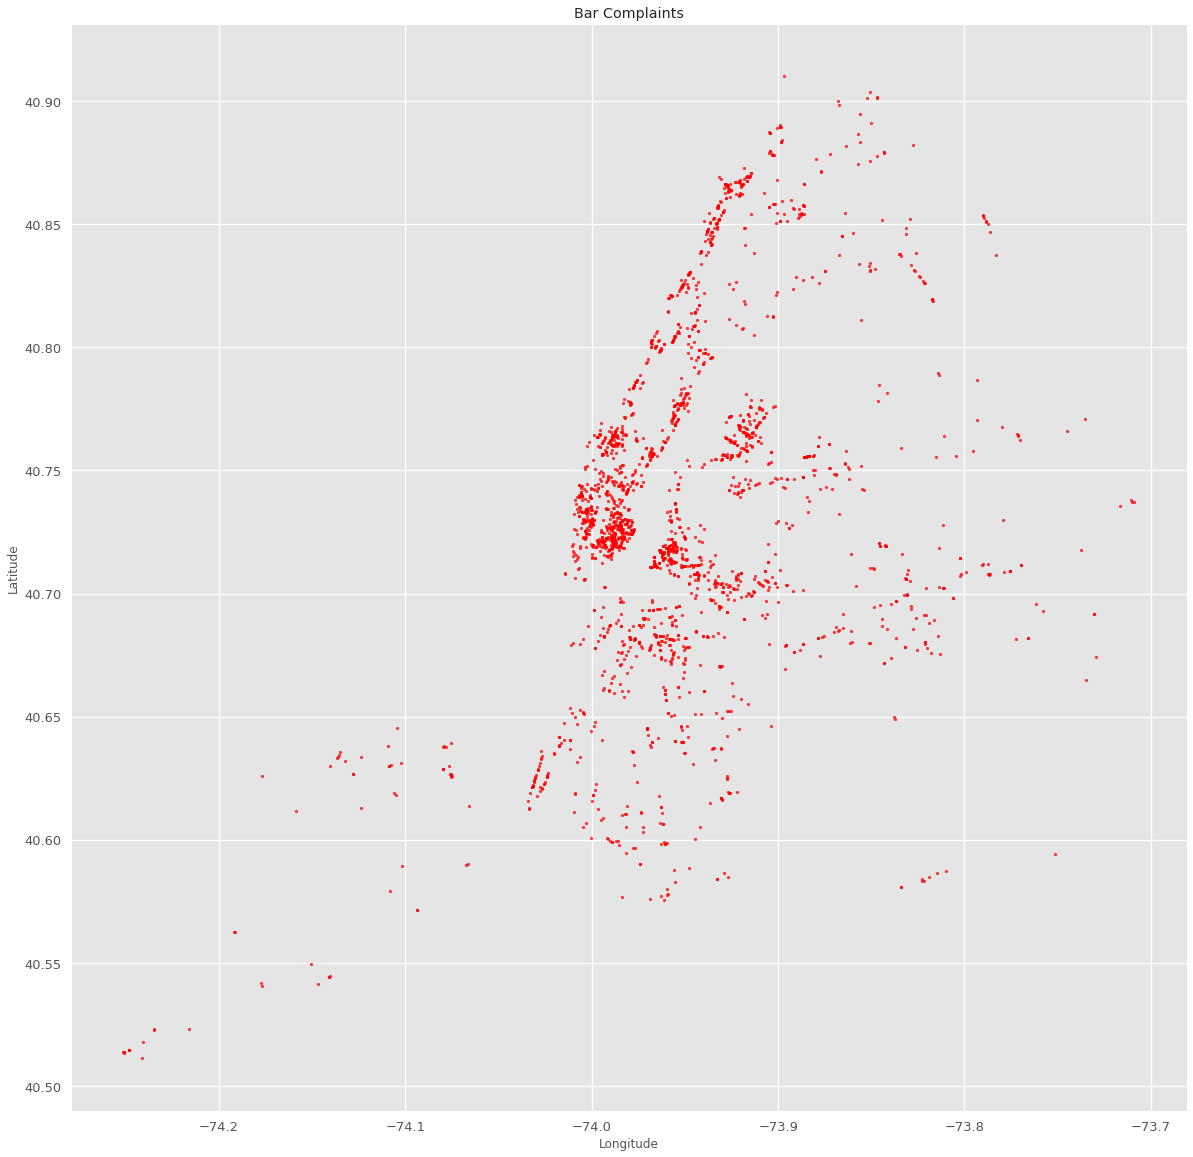

In [452]:
bars [
    (bars.Latitude > 40) & 
    (bars.Latitude < 41) & 
    (bars.Longitude < -50) &
    (bars.Longitude > -74.5) & 
    (bars['uniqueID']>=1) 
].plot (
    kind='scatter',
    x = 'Longitude',
    y = 'Latitude',
    figsize = (20, 20), 
    alpha = 0.75, 
    s = 7,
    color = 'red',
    title = 'Bar Complaints'
)

In [427]:
# Back again
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])

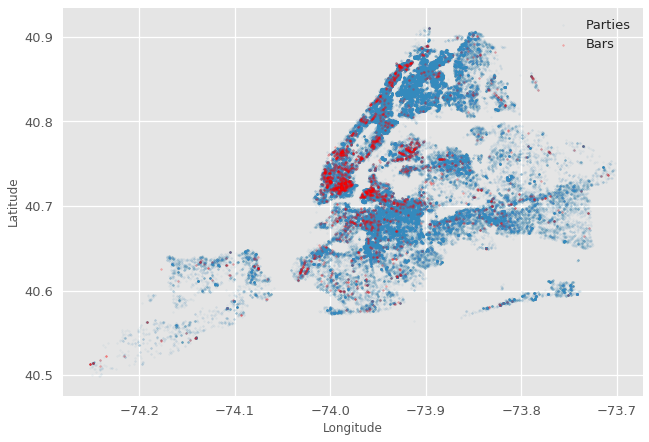

In [492]:
# Found this method on stackoverflow to plot two scatter plots from different dataframes together
ax = parties.reset_index().plot(kind='scatter', x='Longitude', y='Latitude', alpha=0.05, s=3,
                                           label='Parties') 

bars.reset_index().plot(kind='scatter', x='Longitude', y='Latitude', alpha=0.25, s=3,
                                          color='red', label='Bars', ax=ax)


In [375]:
# Looking at the datetime for the parties table, I'd look to see if we can plot the number of complaints
# for just the number of days in the dataset. Let me split off another column here.
parties["Just Date"] = parties['Created Date'].dt.date

In [400]:
pivot = pd.pivot_table(
    data = parties, 
    index = 'Just Date', 
    values = 'Incident Zip', 
    aggfunc = 'count'
)

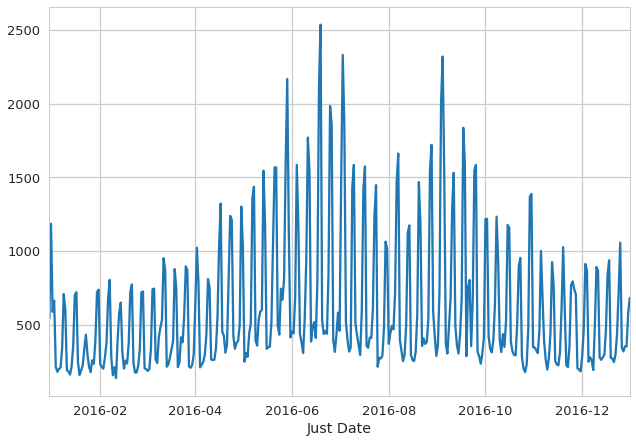

In [406]:
pivot.plot(legend=False)
# Reveals the peak number of loud parties happen in the summer months, especially in June-July

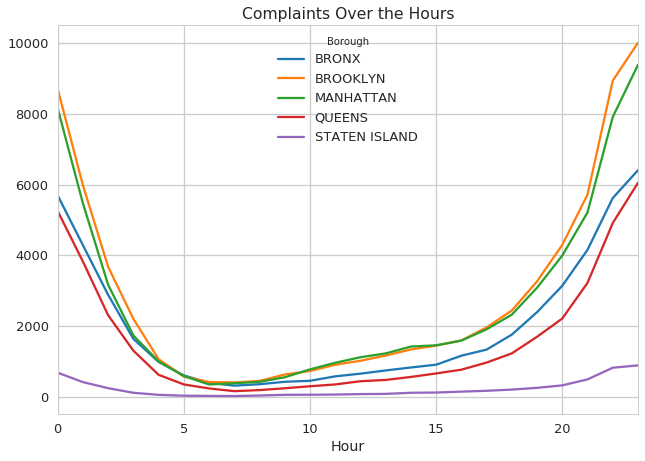

In [336]:
# Taking a look at the evolution of noise complaints across the hours
borough_hour = pd.pivot_table(
    data = parties, #
    index = 'Hour', 
    columns = 'Borough', 
    values = 'Incident Zip', 
    aggfunc = 'count'
)
borough_hour = borough_hour.drop('Unspecified', axis=1)
borough_hour.plot(title='Complaints Over the Hours')

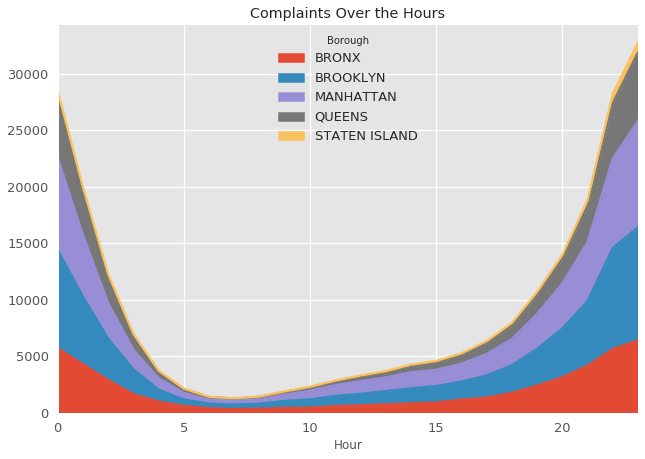

In [671]:
# Nice place to use an area plot
borough_hour.plot.area(title='Complaints Over the Hours')

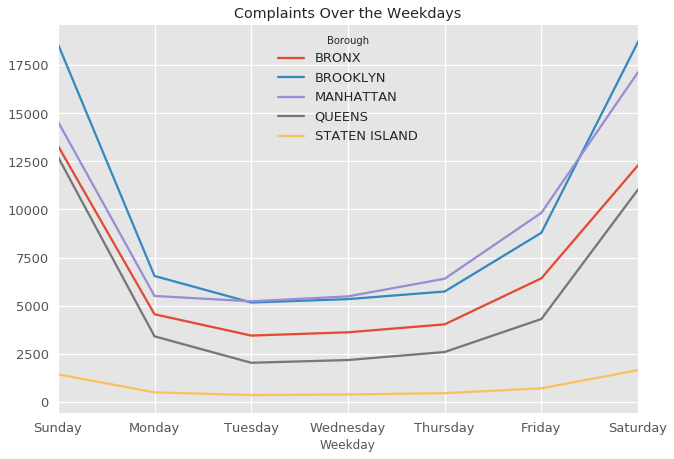

In [561]:
# Taking a look at how the noise complaints evolve depending on the weekday
borough_day = pd.pivot_table(
    data = parties, 
    index = 'Weekday', 
    columns = 'Borough', 
    values = 'Incident Zip', 
    aggfunc = 'count'
)
borough_day = borough_day.drop('Unspecified', axis=1)
# We also had to reindex because it was jumbling everything up
right_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
right_index = sorted(borough_day.index, key=lambda x: right_order.index(x))
borough_day = borough_day.reindex(right_index)
# And finally plot
borough_day.plot(title='Complaints Over the Weekdays')
# Looks very similar to the hours

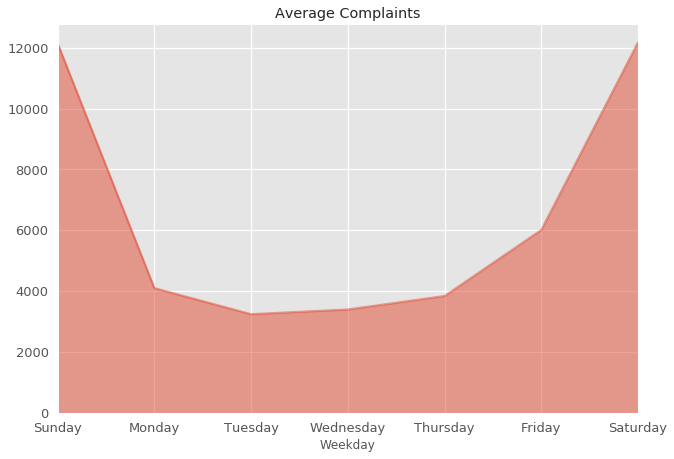

In [672]:
# Let's take a look at the mean
borough_day = pd.pivot_table(
    data = parties, 
    index = 'Weekday', 
    columns = 'Borough', 
    values = 'Incident Zip', 
    aggfunc = 'count'
)
borough_day = borough_day.drop('Unspecified', axis=1)
# We also had to reindex because it was jumbling everything up
right_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
right_index = sorted(borough_day.index, key=lambda x: right_order.index(x))
borough_day = borough_day.reindex(right_index)
# And finally plot
borough_day.mean(axis=1).plot.area(stacked=False, title='Average Complaints')

In [ ]:
# Here are all the other SQL queries we did that were cut from the presentation. Some in this will be repeats.

USE parties_in_nyc;

# Zip codes with the most calls for the bars
SELECT `Incident Zip`, num_calls
FROM bar_complaints 
ORDER BY num_calls DESC;

# Let's look at this zip with the most calls
SELECT City, Borough
FROM bar_complaints
WHERE `Incident Zip` = 11217
LIMIT 1;

#Check the areas around the residence halls
# Let's do the same for all the zips with the most calls
SELECT `Incident Zip`, City, Borough, num_calls
FROM bar_complaints 
ORDER BY num_calls DESC;

# Let's take a look at the number of incidents across all the boroughs
SELECT Borough, SUM(num_calls) AS Sum
FROM bar_complaints 
GROUP BY Borough
ORDER BY Sum DESC;

# Now let's look at each borough separately
SELECT Borough, num_calls
FROM bar_complaints 
WHERE Borough = 'Brooklyn'
ORDER BY num_calls DESC;
# 736 individual instances

SELECT Borough, num_calls
FROM bar_complaints 
WHERE Borough = 'Staten Island'
ORDER BY num_calls DESC;
# 64 instances

SELECT Borough, num_calls
FROM bar_complaints 
WHERE Borough = 'Manhattan'
ORDER BY num_calls DESC;
# 1076 instances

SELECT Borough, num_calls
FROM bar_complaints 
WHERE Borough = 'Queens'
ORDER BY num_calls DESC;
# 418 instances

SELECT Borough, num_calls
FROM bar_complaints 
WHERE Borough = 'Bronx'
ORDER BY num_calls DESC;
# 141 instances

# Now, let's look at the average number of calls
SELECT Borough, AVG(num_calls) AS Avg
FROM bar_complaints
GROUP BY Borough
ORDER BY Avg DESC;

# Now we look at party complaints

# Let's take a look at the most popular zips for private parties
SELECT `Incident Zip`, COUNT(*) as cnt
FROM party_complaints 
GROUP BY `Incident Zip`
ORDER BY cnt DESC;

# Let's now look at the most popular location types
SELECT `Location Type`, COUNT(*) AS cnt
FROM party_complaints
GROUP BY `Location Type`
ORDER BY cnt DESC;

# Number of party complaints per borough
SELECT `Borough`, COUNT(*) AS cnt
FROM party_complaints
GROUP BY `Borough`
ORDER BY cnt DESC;


DESCRIBE party_complaints;
SELECT COUNT(*) FROM party_complaints;
SELECT COUNT(*) FROM bar_complaints;